IMPORT LIBRARIES

**DENOISE ENCODER_DECODER**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


TO GENERATE SAME RESULT EVERYTIME

In [0]:
np.random.seed(1337)

LOAD MNIST DATA, we don't need labels as we won't be using it

In [0]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# x_train = x_train[1:10000]

ADD NOISE TO THE DATA

In [0]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


MAKE ENCODER_DECODER NETWORK

In [0]:
input_shape = (image_size, image_size, 1)
batch_size = 256
kernel_size = 3
latent_dim = 32
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides = 2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')




Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                100384    
Total params: 119,200
Trainable params: 119,200
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Outp

TRAIN NETWORK

In [0]:
# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)




Train on 60000 samples, validate on 10000 samples
Epoch 1/30





60000/60000 [==============================] - 91s 2ms/step - loss: 0.0738 - val_loss: 0.0627
Epoch 2/30
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0436 - val_loss: 0.0291
Epoch 3/30
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0243 - val_loss: 0.0203
Epoch 4/30
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0188 - val_loss: 0.0174
Epoch 5/30
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0165 - val_loss: 0.0158
Epoch 6/30
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 7/30
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 8/30
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 9/30
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0138 - val_loss: 0.01

In [0]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

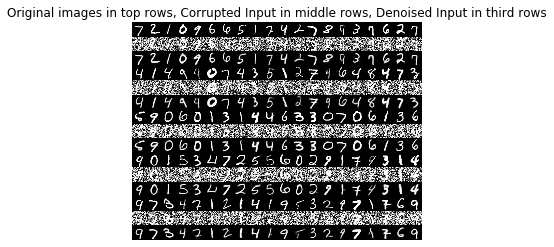

In [0]:
# Display the 1st 8 corrupted and denoised images
rows, cols = 5, 20
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images in top rows, '
          'Corrupted Input in middle rows, '
          'Denoised Input in third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

using the same model layes as early layers


In [0]:
x_train = x_train[1:6000]
y_train = y_train[1:6000]


In [0]:
for layer in encoder.layers[:]:
    layer.trainable = False

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential
# Create the model
model = Sequential()
 
model.add(encoder)

model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Model)              (None, 32)                119200    
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                170       
Total params: 120,170
Trainable params: 970
Non-trainable params: 119,200
_________________________________________________________________


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
# transform training label to one-hot encoding
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
y_train = lb.transform(y_train)


In [0]:
%time model.fit(x=x_train,y=y_train,batch_size=32, epochs=30,validation_split=0.2)

Train on 4799 samples, validate on 1200 samples
Epoch 1/30
4799/4799 [==============================] - 5s 1ms/step - loss: 1.9314 - acc: 0.3645 - val_loss: 1.4201 - val_acc: 0.5833
Epoch 2/30
4799/4799 [==============================] - 1s 161us/step - loss: 1.1328 - acc: 0.6614 - val_loss: 0.8255 - val_acc: 0.7600
Epoch 3/30
4799/4799 [==============================] - 1s 165us/step - loss: 0.7282 - acc: 0.7887 - val_loss: 0.5920 - val_acc: 0.8400
Epoch 4/30
4799/4799 [==============================] - 1s 167us/step - loss: 0.5536 - acc: 0.8404 - val_loss: 0.4939 - val_acc: 0.8600
Epoch 5/30
4799/4799 [==============================] - 1s 166us/step - loss: 0.4640 - acc: 0.8639 - val_loss: 0.4417 - val_acc: 0.8700
Epoch 6/30
4799/4799 [==============================] - 1s 165us/step - loss: 0.4104 - acc: 0.8802 - val_loss: 0.4090 - val_acc: 0.8817
Epoch 7/30
4799/4799 [==============================] - 1s 164us/step - loss: 0.3748 - acc: 0.8904 - val_loss: 0.3851 - val_acc: 0.8825
Ep

In [0]:
predicts = model.evaluate(x_test, lb.transform(y_test))
print("Test Accuracy = " + str(predicts[1]))

10000/10000 [==============================] - 1s 135us/step
Test Accuracy = 0.9111


              precision    recall  f1-score   support

           0       0.92      0.95      0.93       980
           1       0.97      0.97      0.97      1135
           2       0.91      0.87      0.89      1032
           3       0.92      0.89      0.90      1010
           4       0.88      0.95      0.92       982
           5       0.85      0.88      0.86       892
           6       0.93      0.92      0.92       958
           7       0.91      0.90      0.91      1028
           8       0.90      0.88      0.89       974
           9       0.93      0.88      0.90      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



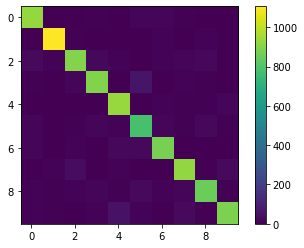

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model.predict_classes(x_test)))
cm = confusion_matrix(y_test, model.predict_classes(x_test))
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.imshow(cm)
fig.colorbar(im)
plt.show()
# plt.imshow(cm)

WITH FULL DATA

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 8s 172us/step - loss: 0.2998 - acc: 0.9095 - val_loss: 0.2739 - val_acc: 0.9203
Epoch 2/30
48000/48000 [==============================] - 8s 169us/step - loss: 0.2723 - acc: 0.9191 - val_loss: 0.2593 - val_acc: 0.9248
Epoch 3/30
48000/48000 [==============================] - 8s 174us/step - loss: 0.2580 - acc: 0.9221 - val_loss: 0.2504 - val_acc: 0.9297
Epoch 4/30
48000/48000 [==============================] - 9s 182us/step - loss: 0.2465 - acc: 0.9254 - val_loss: 0.2434 - val_acc: 0.9311
Epoch 5/30
48000/48000 [==============================] - 9s 177us/step - loss: 0.2375 - acc: 0.9285 - val_loss: 0.2399 - val_acc: 0.9321
Epoch 6/30
48000/48000 [==============================] - 9s 181us/step - loss: 0.2314 - acc: 0.9297 - val_loss: 0.2322 - val_acc: 0.9335
Epoch 7/30
48000/48000 [==============================] - 8s 172us/step - loss: 0.2260 - acc: 0.9313 - val_loss: 0.2283 - 

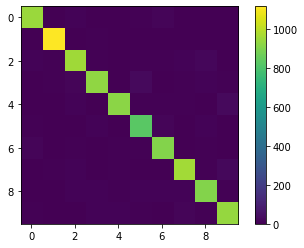

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
y_train = lb.transform(y_train)

%time model.fit(x=x_train,y=y_train,batch_size=32, epochs=30,validation_split=0.2)

predicts = model.evaluate(x_test, lb.transform(y_test))
print("Test Accuracy = " + str(predicts[1]))
print(classification_report(y_test, model.predict_classes(x_test)))
cm = confusion_matrix(y_test, model.predict_classes(x_test))
fig, ax = plt.subplots()
im = ax.imshow(cm)
fig.colorbar(im)
plt.show()


In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def vis_img_in_filter(img=np.array(x_train[1]).reshape((1, 28, 28, 1)).astype(np.float64),
                      layer_name='conv2d_2',model = model):
    layer_output = layer_dict[layer_name].output
    print(layer_output.shape)
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))

    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 8, 8
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize=(12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap='gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad=0.3, rect=[0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap='gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))



In [0]:
layer_dict = dict([(layer.name, layer) for layer in encoder.layers])
print(layer_dict)

{'encoder_input': <keras.engine.input_layer.InputLayer object at 0x7fbad4fef940>, 'conv2d_1': <keras.layers.convolutional.Conv2D object at 0x7fbad4fefa58>, 'conv2d_2': <keras.layers.convolutional.Conv2D object at 0x7fbad4fefc88>, 'flatten_1': <keras.layers.core.Flatten object at 0x7fbad4fef978>, 'latent_vector': <keras.layers.core.Dense object at 0x7fbad4fefb38>}


In [0]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                100384    
Total params: 119,200
Trainable params: 119,200
Non-trainable params: 0
_________________________________________________________________


(?, 14, 14, 32)


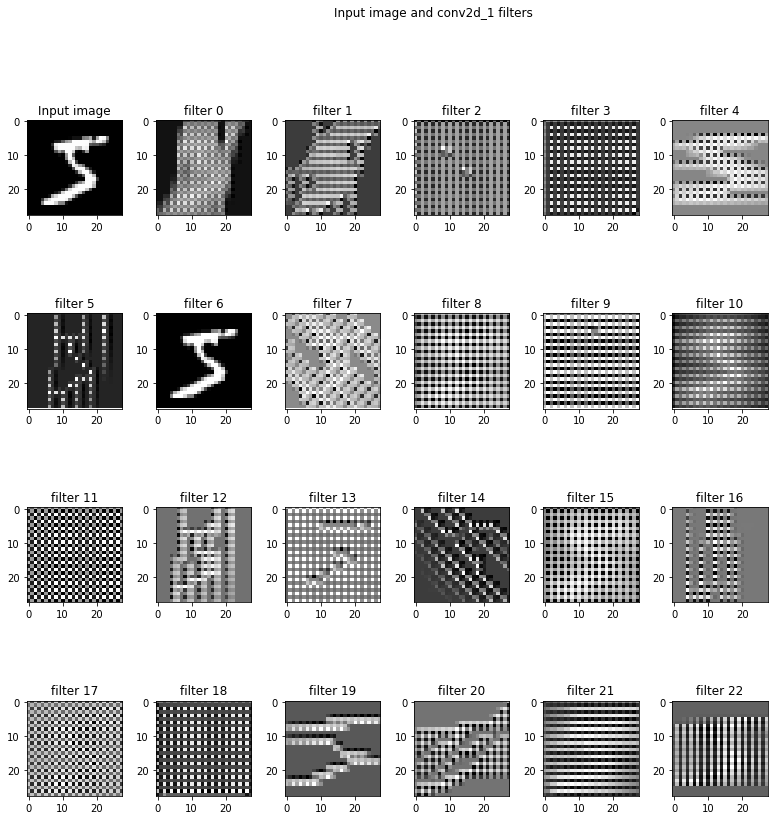

In [0]:
for layer in encoder.layers[:]:
    layer.trainable = True
vis_img_in_filter(img=np.array(x_train[0]).reshape((1, 28, 28, 1)).astype(np.float64),layer_name='conv2d_1', model = autoencoder)
plt.show()

(?, 7, 7, 64)


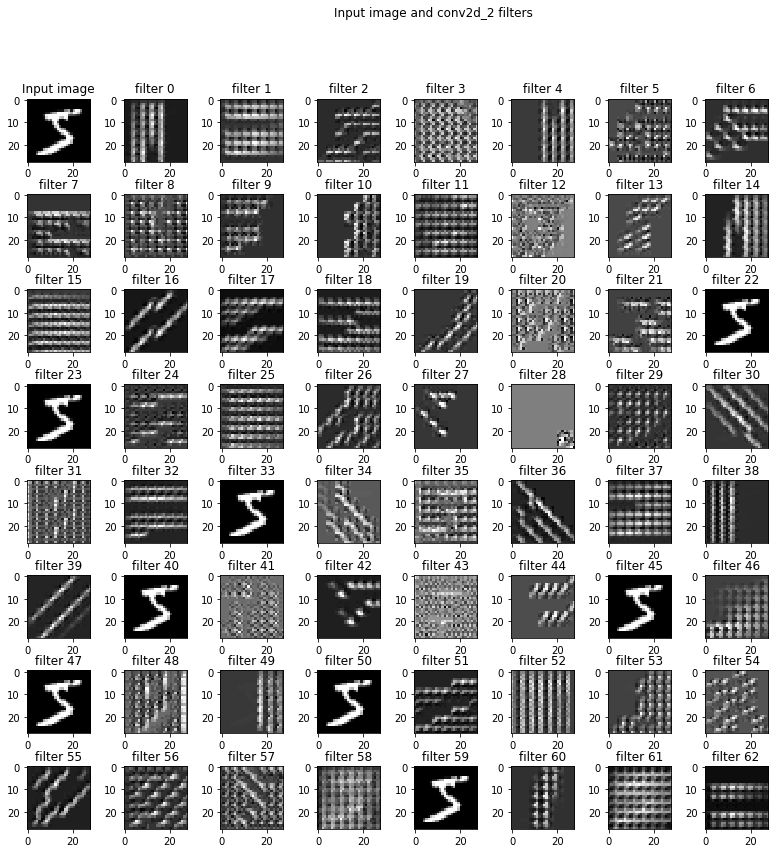

In [0]:
vis_img_in_filter(img=np.array(x_train[0]).reshape((1, 28, 28, 1)).astype(np.float64),layer_name='conv2d_2', model = autoencoder)
plt.show()